# **Quality Control and Preprocessing Overview**

This notebook performs quality control (QC) for single-cell RNA-seq data using Scanpy. It includes visualization of raw data metrics, statistical summaries, and filtering steps to remove low-quality cells. This ensures clean and interpretable input for downstream analyses such as clustering and differential expression.


In [20]:
import matplotlib.pyplot as plt
import scanpy as sc

adata = sc.read_h5ad("../nCoV_dataset_full.h5ad")

## **Visualizing Raw Quality Metrics**

This section generates violin plots of unfiltered data to assess QC features including total counts, number of genes per cell, and mitochondrial gene expression.


       n_genes_by_counts  total_counts
count       46022.000000  46022.000000
mean          814.039959   1774.544597
std           429.381440    408.142982
min           298.000000    780.045361
25%           559.000000   1489.566982
50%           717.000000   1726.779466
75%           946.000000   2012.330623
max          5993.000000   4213.337036
       n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt
count       46022.000000  46022.000000     46022.000000   46022.000000
mean          814.039959   1774.544597        20.537330       1.155392
std           429.381440    408.142982        10.133948       0.560477
min           298.000000    780.045361         0.000000       0.000000
25%           559.000000   1489.566982        12.681962       0.760052
50%           717.000000   1726.779466        20.010315       1.078060
75%           946.000000   2012.330623        27.662197       1.485755
max          5993.000000   4213.337036        60.184846       4.877690


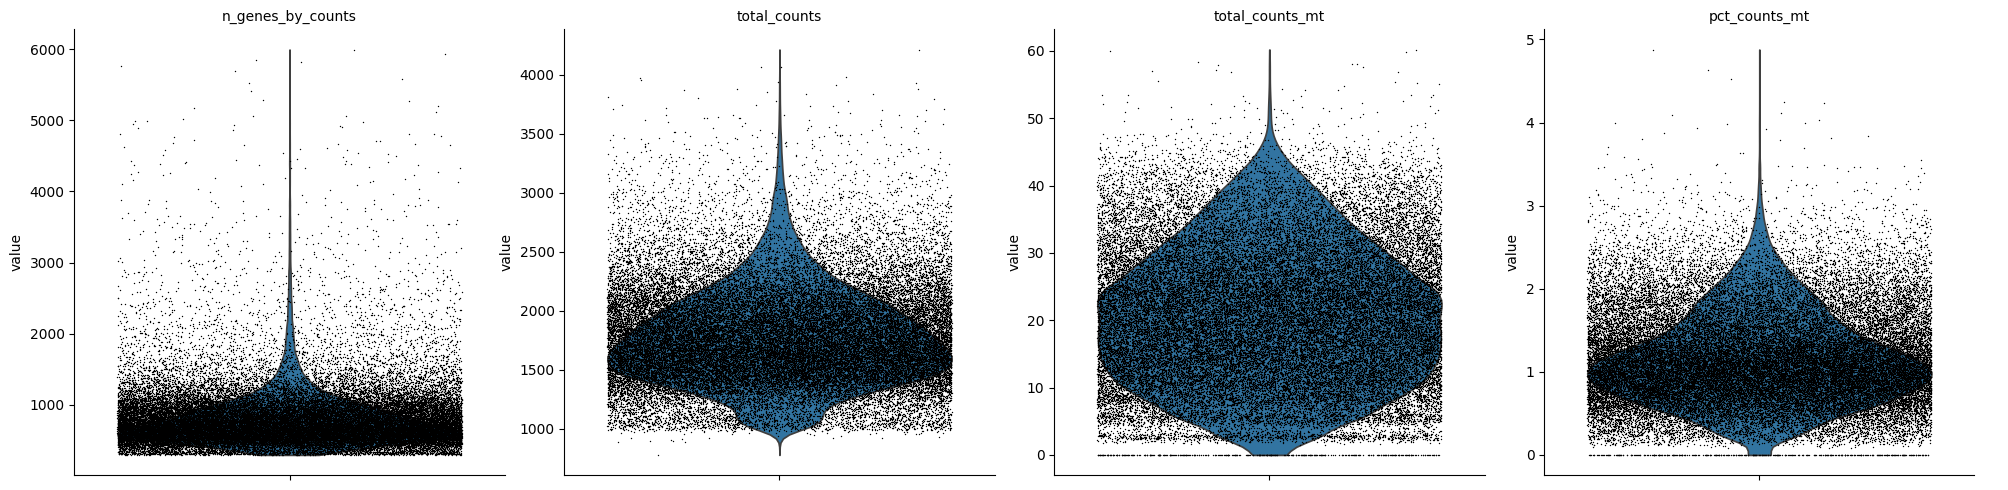

In [22]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False,
    inplace=True
)

print(adata.obs[["n_genes_by_counts", "total_counts"]].describe())
print(adata.obs[["n_genes_by_counts", "total_counts", "total_counts_mt", "pct_counts_mt"]].describe())

sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)


## **Computing and Plotting QC Statistics**

Here we compute basic statistics on total counts and gene counts across cells. Histograms are plotted to visualize the global distributions and inform decisions on appropriate QC cutoffs. Dotted lines show 2 standard deviations above and below the mean.


In [25]:
# Calculating gene and count thresholds to apply outlier filtering

gene_stats = adata.obs['n_genes_by_counts'].describe()
count_stats = adata.obs['total_counts'].describe()

mean_genes = gene_stats['mean']
std_genes = adata.obs['n_genes_by_counts'].std()

mean_counts = count_stats['mean']
std_counts = adata.obs['total_counts'].std()

min_genes = max(mean_genes - 2 * std_genes, 300)
max_genes = mean_genes + 2 * std_genes

min_counts = max(mean_counts - 2 * std_counts, 500)
max_counts = mean_counts + 2 * std_counts

print(f"min_genes = {min_genes:.1f}, max_genes = {max_genes:.1f}")
print(f"min_counts = {min_counts:.1f}, max_counts = {max_counts:.1f}")

min_genes = 300.0, max_genes = 1672.8
min_counts = 958.3, max_counts = 2590.8


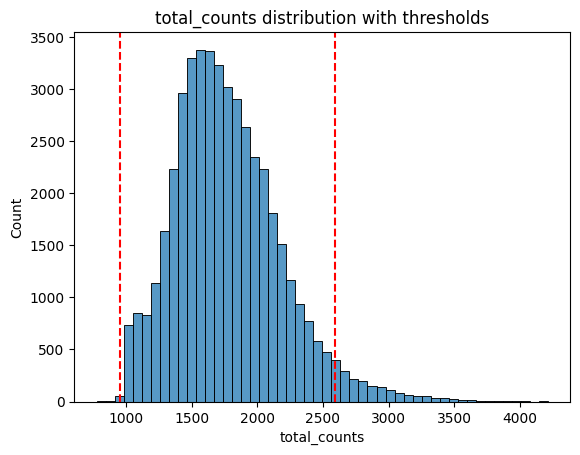

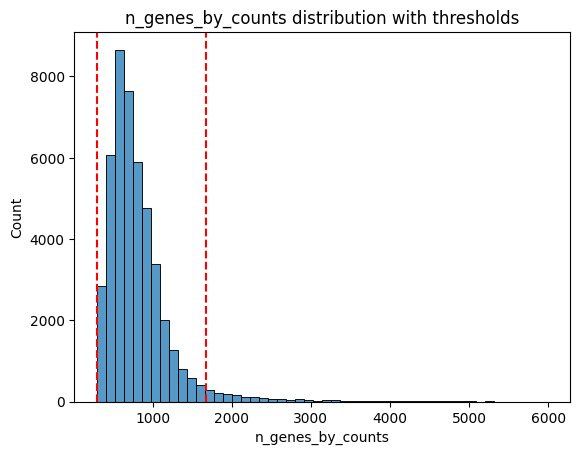

In [26]:
import seaborn as sns

sns.histplot(adata.obs['total_counts'], bins=50)
plt.axvline(min_counts, color='red', linestyle='--')
plt.axvline(max_counts, color='red', linestyle='--')
plt.title("total_counts distribution with thresholds")
plt.show()

sns.histplot(adata.obs['n_genes_by_counts'], bins=50)
plt.axvline(min_genes, color='red', linestyle='--')
plt.axvline(max_genes, color='red', linestyle='--')
plt.title("n_genes_by_counts distribution with thresholds")
plt.show()

## **Filtering Low-Quality Cells**

Based on insights from the earlier visualizations, this section filters out cells with abnormally low or high total counts, gene counts, or mitochondrial percentages. The resulting dataset is cleaner and more suitable for downstream analysis, plotted as violin plots below.

Original number of cells: 46022
Original number of genes: 18824
Original matrix sparsity: 0.9568
Cells removed (fewer than 300 genes): 3
Genes removed (expressed in <10 cells): 2282
Cells removed (mito % > 25): 0
Cells removed (extreme outliers): 2086
Cells removed (low total counts): 20
Filtered matrix sparsity: 0.9548
Final number of cells: 43913
Final number of genes: 16542


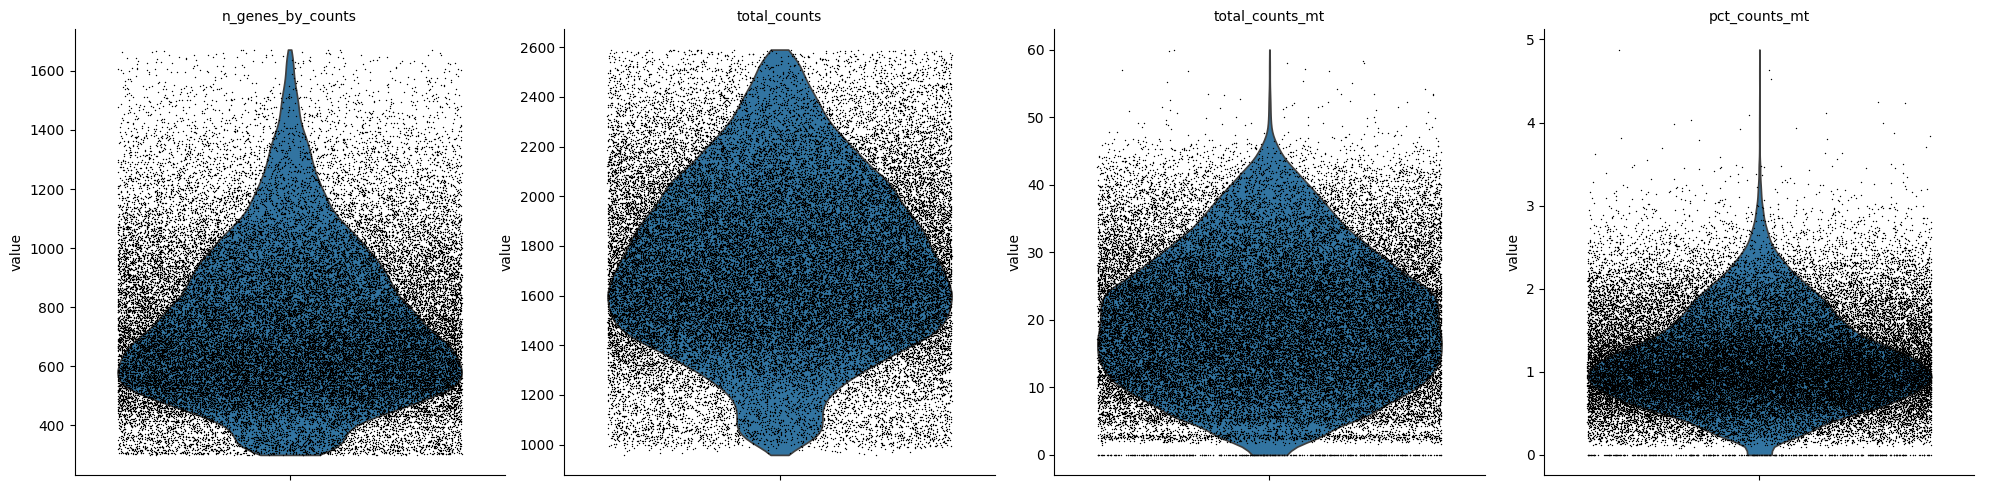

In [27]:
import numpy as np

# Reusing much of the code from HW3

# Print number of cells and genes before filtering
print(f"Original number of cells: {adata.n_obs}")
print(f"Original number of genes: {adata.n_vars}")

# Find sparsity.
sparsity = 1 - (np.sum(adata.X != 0) / np.prod(adata.shape))
print(f"Original matrix sparsity: {sparsity:.4f}")

# Filter cells with <300 genes.
initial_n_cells = adata.n_obs
sc.pp.filter_cells(adata, min_genes=300)
filtered_cells_b = initial_n_cells - adata.n_obs
print(f"Cells removed (fewer than 300 genes): {filtered_cells_b}")

# Filter genes not expressed in > 10 cells.
initial_n_genes = adata.n_vars
sc.pp.filter_genes(adata, min_cells=10)
filtered_genes_c = initial_n_genes - adata.n_vars
print(f"Genes removed (expressed in <10 cells): {filtered_genes_c}")

# Filter cells with >25% mitochondrial content.
initial_n_cells_d = adata.n_obs
mito_filter = adata.obs['pct_counts_mt'] < 25
adata = adata[mito_filter].copy()
filtered_cells_d = initial_n_cells_d - adata.n_obs
print(f"Cells removed (mito % > 25): {filtered_cells_d}")

# Remove extreme outliers.
initial_n_cells_e = adata.n_obs
extreme_filter = (
    (adata.obs['n_genes_by_counts'] <= max_genes) &
    (adata.obs['total_counts'] <= max_counts)
)
adata = adata[extreme_filter].copy()
filtered_cells_e = initial_n_cells_e - adata.n_obs
print(f"Cells removed (extreme outliers): {filtered_cells_e}")

# Remove low-quality cells.
initial_n_cells_f = adata.n_obs
low_quality_filter = (
    (adata.obs['n_genes_by_counts'] >= min_genes) &
    (adata.obs['total_counts'] >= min_counts)
)
adata = adata[low_quality_filter].copy()
filtered_cells_f = initial_n_cells_f - adata.n_obs
print(f"Cells removed (low total counts): {filtered_cells_f}")

# Calculate new sparsity.
new_sparsity = 1 - (np.sum(adata.X != 0) / np.prod(adata.shape))
print(f"Filtered matrix sparsity: {new_sparsity:.4f}")

# Print number of cells and genes after filtering
print(f"Final number of cells: {adata.n_obs}")
print(f"Final number of genes: {adata.n_vars}")

# Plot QC metrics after filtering. 
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)